In [1]:
%matplotlib inline

In [2]:
import sys
import os 
from glob import glob

In [3]:
sys.path.insert(0, '../../')

In [4]:
import paleopy

In [5]:
from paleopy import plotting

In [6]:
plotting.scalar_plot

paleopy.plotting.scalar_plot.scalar_plot

In [7]:
from paleopy import Proxy 
from paleopy import Analogs
from paleopy import Ensemble
from paleopy.plotting import scalar_plot

In [8]:
djsons = '../../jsons/'
pjsons = '../../jsons/proxies'

In [9]:
from numpy import ma
import numpy as np
import xarray as xray

### test the new implementation of PALEOPY with just one proxy

In [10]:
p = Proxy(sitename='Rarotonga', \
          lon = -159.82, \
          lat = -21.23, \
          djsons = djsons, \
          pjsons = pjsons, \
          pfname = 'Rarotonga.json', \
          dataset = 'ersst', \
          variable ='sst', \
          measurement ='delta O18', \
          dating_convention = 'absolute', \
          calendar = 'gregorian',\
          chronology = 'historic', \
          season = 'DJF', \
          value = 0.6, \
          qualitative = 0, \
          calc_anoms = 1, \
          detrend = 1, \
        method = 'quintiles')

In [11]:
p.find_analogs()

In [12]:
p.proxy_repr(pprint=True, outfile=False)

{
sitename:Rarotonga
proxy_type:None
measurement:delta O18
dating_convention:absolute
calendar:gregorian
chronology:historic
coords:(200.18, -21.23)
aspect:None
elevation:None
season:DJF
dataset:ersst
variable:sst
calc_anoms:True
detrend:True
value:0.6
climatology:(1981, 2010)
period:(1979, 2014)
extracted_coords:[200.0, -22.0]
distance_point:87.56368858840081
trend_params:{'intercept': -60.965016377755163, 'slope': 0.030535947029886677}
category:WA
analog_years:[1982, 1997, 1999, 2000, 2001, 2006, 2009]
weights:[0.15645480307020584, 0.12800536294956205, 0.13090508326029401, 0.16334634614636281, 0.15762466128135916, 0.1220029495538857, 0.1416607937383304]
}


In [13]:
p.analog_years

array([1982, 1997, 1999, 2000, 2001, 2006, 2009], dtype=int32)

In [14]:
p.season

'DJF'

In [15]:
p.analogs

,d_anomalies,cat,weights
time,,,
1982-02-15,0.638992,WA,0.156455
1997-02-15,0.747619,WA,0.128005
1999-02-15,0.736547,WA,0.130905
2000-02-15,0.612678,WA,0.163346
2001-02-15,0.565475,WA,0.157625
2006-02-15,0.429462,WA,0.122003
2009-02-15,0.504521,WA,0.141661


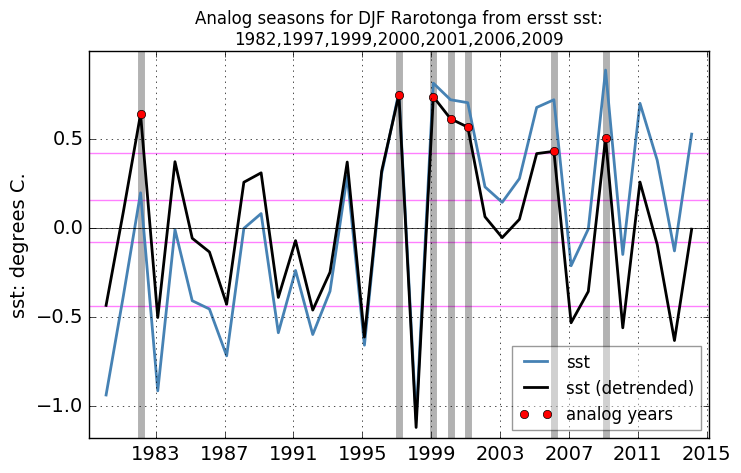

In [16]:
f = p.plot_season_ts()

In [17]:
a = Analogs(p, 'ncep', 'hgt_1000')

In [18]:
a.composite()

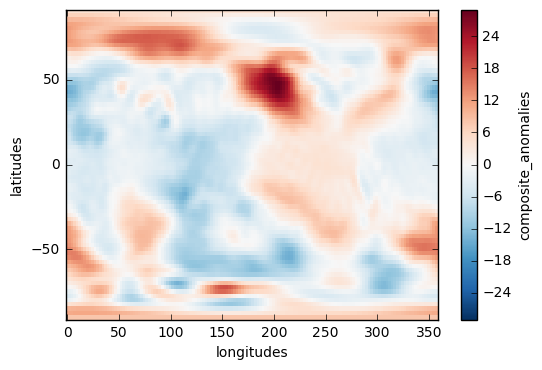

In [19]:
a.dset['composite_anomalies'].plot()

### now test with an ensemble

In [20]:
ens = Ensemble(djsons=djsons, pjsons=pjsons)


            seasons and method [`detrend` or not] are consistent among proxies,
            the composite anomalies for each proxy can be calculated
            for the ensemble as a whole using the extended list of analog years
            


In [21]:
ens


        Ensemble made of 25 proxies
        ------------------
        proxies sitenames:
Amedee
Avoca
Browning Creek
Cameron
Caples
Cass
Clarke
Crow
Falls Creek
Frances
Fraser
Greenlaw
Gunn
Hopkins
Hunter
Jollie
Mistake
Oroko
Pear Drop
Pyke
Rarotonga
Taramakau
Temple
Turnbull
Washington Isl.

In [22]:
b = Analogs(ens, 'ncep', 'hgt_1000')

In [33]:
b.composite()

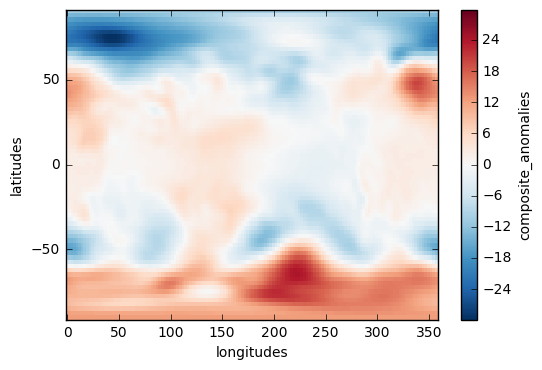

In [35]:
b.dset['composite_anomalies'].plot()

In [34]:
b._composite()

KeyError: 'seas_var'

In [24]:
b.analog_years.__len__()

175

In [25]:
compos_s = xray.concat([b.dset['seas_var'].sel(dates=str(y)) for y in b.analog_years], dim='dates')

In [26]:
clim = b.dset['seas_var'].sel(dates=slice(str(b.parent.climatology[0]), \
                                                     str(b.parent.climatology[1])))

In [27]:
compos_a = compos_s - clim.mean('dates')

In [28]:
# get the composite anomalies into a DataArray
compos_a_x = xray.DataArray(ma.masked_array(compos_a, np.isnan(compos_a)), dims=('years','latitudes','longitudes'),
                      coords={'years':b.analog_years, 'latitudes':b.dset.latitudes, 'longitudes':b.dset.longitudes})

In [29]:
from scipy.stats import ttest_ind

In [30]:
t, pvalues = ttest_ind(compos_s.data, clim.data, axis=0)

In [31]:
ayears = b.analog_years

In [32]:
dset = b.dset.drop(('dates','time'))

# store the anomalies and the composite anomalies
# in the xray Dataset

dset['years'] = (('years',), ayears)

dset['composite_sample'] = compos_a_x

dset['composite_anomalies'] = compos_a_x.mean('years')

dset['weights'] = xray.DataArray(np.array(b.parent.weights), dims=('years'), coords={'years':compos_a_x.years.data})

# saves the p-values
dset['pvalues'] = (('latitudes', 'longitudes'), pvalues)

# set the attributes
dset['latitudes'].attrs['units'] = 'degrees_north'
dset['latitudes'].attrs['long_name'] = 'Latitudes'
dset['latitudes'].attrs['axis'] = 'Y'
dset['longitudes'].attrs['units'] = 'degrees_east'
dset['longitudes'].attrs['long_name'] = 'Longitudes'
dset['longitudes'].attrs['axis'] = 'X'
dset['composite_sample'].attrs['missing_value'] = -999.9
dset['composite_sample'].attrs['_FillValue'] = -999.9
dset['composite_anomalies'].attrs['missing_value'] = -999.9
dset['composite_anomalies'].attrs['_FillValue'] = -999.9

ValueError: conflicting sizes for dimension 'years': length 0 on the data but length 175 on coordinate 'years'